# https://towardsdatascience.com/an-in-depth-efficientnet-tutorial-using-tensorflow-how-to-use-efficientnet-on-a-custom-dataset-1cab0997f65c

first import the neccessary stuff and check if the gpu is available

In [1]:
from keras.applications import * #Efficient Net included here
from keras import models
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
import timm
import numpy as np
import os
import shutil
import pandas as pd
from sklearn import model_selection
from tqdm import tqdm
from keras import optimizers
import tensorflow as tf #Use this to check if the GPU is configured correctly
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12871676832170268649
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2915486926
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5178691207143284934
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:2d:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


setup a model

In [2]:
height, width = 440,440
input_shape=(height,width, 3)
conv_base = EfficientNetB6(weights="imagenet", include_top=False, input_shape=input_shape)

model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D(name="gap"))
#avoid overfitting
model.add(layers.Dropout(rate=0.2, name="dropout_out"))
# Set NUMBER_OF_CLASSES to the number of your final predictions.
NUMBER_OF_CLASSES = 10
model.add(layers.Dense(NUMBER_OF_CLASSES, activation="softmax", name="fc_out"))
conv_base.trainable = False

setup dirs for training and validation files

In [7]:
TRAIN_IMAGES_PATH = './imagenette2-160/images/train' #12000
VAL_IMAGES_PATH = './imagenette2-160/images/val' #3000
os.makedirs(TRAIN_IMAGES_PATH, exist_ok = True)
os.makedirs(VAL_IMAGES_PATH, exist_ok = True)

classes = [ "n01440764", "n02102040", "n02979186", "n03000684", "n03028079", "n03394916", "n03417042", "n03425413", "n03445777", "n03888257"]# Create directories for each class.
for class_id in [x for x in range(len(classes))]:
    os.makedirs(os.path.join(TRAIN_IMAGES_PATH, str(classes[class_id])), exist_ok = True)
    os.makedirs(os.path.join(VAL_IMAGES_PATH, str(classes[class_id])), exist_ok = True)

Input_dir = './imagenette2-160/'
def preproccess_data(df, images_path):
    for column, row in tqdm(df.iterrows(), total=len(df)):
        class_id = row['noisy_labels_0']

        shutil.copy(os.path.join(Input_dir, f"{row['path']}"), os.path.join(images_path, str(class_id)))

load the images

In [9]:
df = pd.read_csv('./imagenette2-160/noisy_imagenette.csv')
df.head()#Split the dataset into 80% training and 20% validation
df_train, df_valid = model_selection.train_test_split(df, test_size=0.2, random_state=42, shuffle=True)#run the  function on each of them
preproccess_data(df_train, TRAIN_IMAGES_PATH)
preproccess_data(df_valid, VAL_IMAGES_PATH)

100%|██████████| 2679/2679 [00:01<00:00, 1410.36it/s]


sss

In [10]:
# I love the  ImageDataGenerator class, it allows us to specifiy whatever augmentations we want so easily...
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)# Note that the validation data should not be augmented!#and a very important step is to normalise the images through  rescaling
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

batch_size = 16

train_generator = train_datagen.flow_from_directory(
    # This is the target directory
    TRAIN_IMAGES_PATH,
    # All images will be resized to target height and width.
    target_size=(height, width),
    batch_size=batch_size,
    # Since we use categorical_crossentropy loss, we need categorical labels
    class_mode="categorical",
)
validation_generator = test_datagen.flow_from_directory(
    VAL_IMAGES_PATH,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode="categorical",
)
model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.RMSprop(lr=2e-5),
    metrics=["acc"],
)

Found 10715 images belonging to 10 classes.
Found 2679 images belonging to 10 classes.


c:\Users\profc\.conda\envs\Datamining\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


sss

In [11]:
#Train
epochs = 1
NUMBER_OF_TRAINING_IMAGES = 10715
NUMBER_OF_VALIDATION_IMAGES = 2679
history = model.fit(
    train_generator,
    steps_per_epoch=NUMBER_OF_TRAINING_IMAGES // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=NUMBER_OF_VALIDATION_IMAGES // batch_size,
    verbose=1,
    use_multiprocessing=False,
    workers=6,
)

669/669 [==============================] - 1081s 2s/step - loss: 12.1939 - acc: 0.1030 - val_loss: 3.3900 - val_acc: 0.0977


Found 50 images belonging to 1 classes.


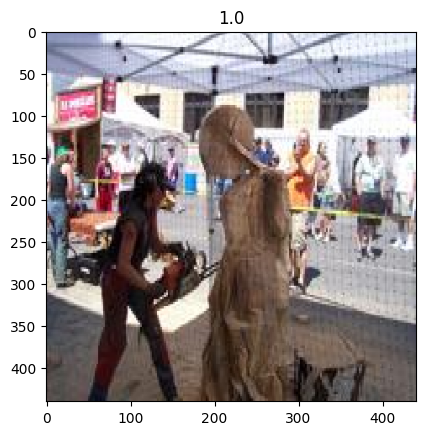

1/1 [==============================] - 0s 60ms/step
y_pred shape (16, 10)
predicted! Parachutes [0.07892706 0.07470057 0.0231003  0.00532129 0.02127111 0.59023285
 0.00904235 0.02201341 0.05926566 0.11612535]
1/1 [==============================] - 1s 1s/step - loss: 33.2048 - acc: 0.0000e+00
scored! [33.204811096191406, 0.0]
0 [0.07892706 0.07470057 0.0231003  0.00532129 0.02127111 0.59023285
 0.00904235 0.02201341 0.05926566 0.11612535]
1 [0.0514648  0.03164352 0.02602903 0.00311818 0.02341722 0.6600408
 0.00605822 0.01250185 0.03112508 0.15460128]
2 [0.06037714 0.0424353  0.02484897 0.00372453 0.02278953 0.64655364
 0.00674138 0.01491533 0.0400293  0.13758491]
3 [0.06832659 0.06045892 0.02320692 0.0044534  0.0211686  0.61791074
 0.00785576 0.01802347 0.0531187  0.12547694]
4 [0.04983162 0.03008174 0.02582872 0.00295839 0.02311761 0.66640365
 0.00588174 0.01215011 0.02952887 0.15421753]
5 [0.07062453 0.06133198 0.02573177 0.00504193 0.0230541  0.6126493
 0.00830144 0.01896345 0.049682

ValueError: Found input variables with inconsistent numbers of samples: [1, 10]

In [63]:
import matplotlib.pyplot as plt
names = {"n01440764": "Fishes",
         "n02102040": "Dogs", 
         "n02979186": "PortableMusicPlayers", 
         "n03000684": "Chainsaws", 
         "n03028079": "Churchs", 
         "n03394916": "Horns", 
         "n03417042": "GarbageTrucks", 
         "n03425413": "GasPumps", 
         "n03445777": "GolfBalls", 
         "n03888257": "Parachutes"}
names = ["Fishes", "Dogs", "PortableMusicPlayers", "Chainsaws", "Churchs", "Horns", "GarbageTrucks", "GasPumps", "GolfBalls",  "Parachutes"]

TEST_IMAGES_PATH = "./imagenette2-160/images/test"
test_generator = test_datagen.flow_from_directory(
    TEST_IMAGES_PATH,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode="categorical",
)

# TODO: how to map to names?
def getPredName(preds):
    max = 0
    index = -1
    for i in range(10):
        if preds[i] > max: 
            max = preds[i]
            index = i
    return names[i]


for sample in test_generator:
    #these are batches of samples, batchsize was defined before
    #print(type(sample)) #tuple
    x_test, y_test = sample
    #print(np.shape(x_test),np.shape(y_test)) #(16, 440, 440, 3) (16, 1)
    #print(np.shape(x_test[0]),np.shape(y_test[0][0])) #(440, 440, 3) ()
    plt.title(y_test[0][0])
    plt.imshow(x_test[0], cmap="brg")
    plt.show()

    #predict
    y_pred = model.predict(x_test)
    print("y_pred shape", np.shape(y_pred)) # (16, 10)
    print("predicted!", getPredName(y_pred[0]), y_pred[0])
    score = model.evaluate(x_test,y_test,verbose=1)
    print("scored!", score)
    for i in range(batch_size):
        print(i, y_pred[i])

    #evaluate
    # Import the modules from `sklearn.metrics` 
    from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score# Confusion matrix confusion_matrix(y_test, y_pred) 

    # TODO: Bugfix the following calls
    ps = precision_score(y_test[0], y_pred[0])
    rs = recall_score(y_test, y_pred)
    f1 = f1_score(y_test,y_pred)
    print(ps, rs, f1)